# **Customer Churn Prediction**

#### **What is customer churn?**  
Customer churn refers to the percentage of customers who stop using a company's product or service within a given time frame. This metric helps businesses gauge customer satisfaction and loyalty while also providing insights into potential revenue fluctuations.

Churn is especially critical for subscription-based businesses, such as SaaS companies, which rely on recurring revenue. Understanding churn patterns allows them to anticipate financial impact and take proactive measures.

Also known as customer attrition, churn is the opposite of customer retention, which focuses on maintaining long-term customer relationships. Reducing churn should be a key part of any customer engagement strategy, ensuring consistent interactions between businesses and their customers, whether online or in person.

A strong customer retention plan plays a crucial role in minimizing churn. Companies should track churn rates regularly to assess their risk of revenue loss and identify areas for improvement.

<br>

**Source:** IBM. Customer Churn. Retrieved from https://www.ibm.com/think/topics/customer-churn

---

### **Prepare the data and packages**

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [131]:
pd.pandas.set_option('display.max_columns',None)

train_path = '../data/CustomerChurnDataset/customer_churn_dataset-testing-master.csv'
test_path = '../data/CustomerChurnDataset/customer_churn_dataset-training-master.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

### **Exploratory Data Analysis**

In [132]:
print(test_df.shape)
test_df.head()

(440833, 12)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [133]:
print(train_df.shape)
train_df.head()

(64374, 12)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [134]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


In [135]:
train_df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000
mean,32187.500000,41.970982,31.994827,15.080234,5.400690,17.133952,541.023379,15.498850,0.473685
std,18583.317451,13.924911,17.098234,8.816470,3.114005,8.852211,260.874809,8.638436,0.499311
min,1.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,16094.250000,30.000000,18.000000,7.000000,3.000000,10.000000,313.000000,8.000000,0.000000
50%,32187.500000,42.000000,33.000000,15.000000,6.000000,19.000000,534.000000,15.000000,0.000000
75%,48280.750000,54.000000,47.000000,23.000000,8.000000,25.000000,768.000000,23.000000,1.000000
max,64374.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


- Identify Numerical and Categorical Features.

In [136]:
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_features = train_df.select_dtypes(include=['int64','float64']).columns.tolist()

print(categorical_features)
print(numerical_features)

['Gender', 'Subscription Type', 'Contract Length']
['CustomerID', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']


- Plot the distribution of numerical features

In [137]:
numerical_features_no_churn = [feature for feature in numerical_features if feature != 'Churn'] # exclude churn from numerical features since we will check it separately

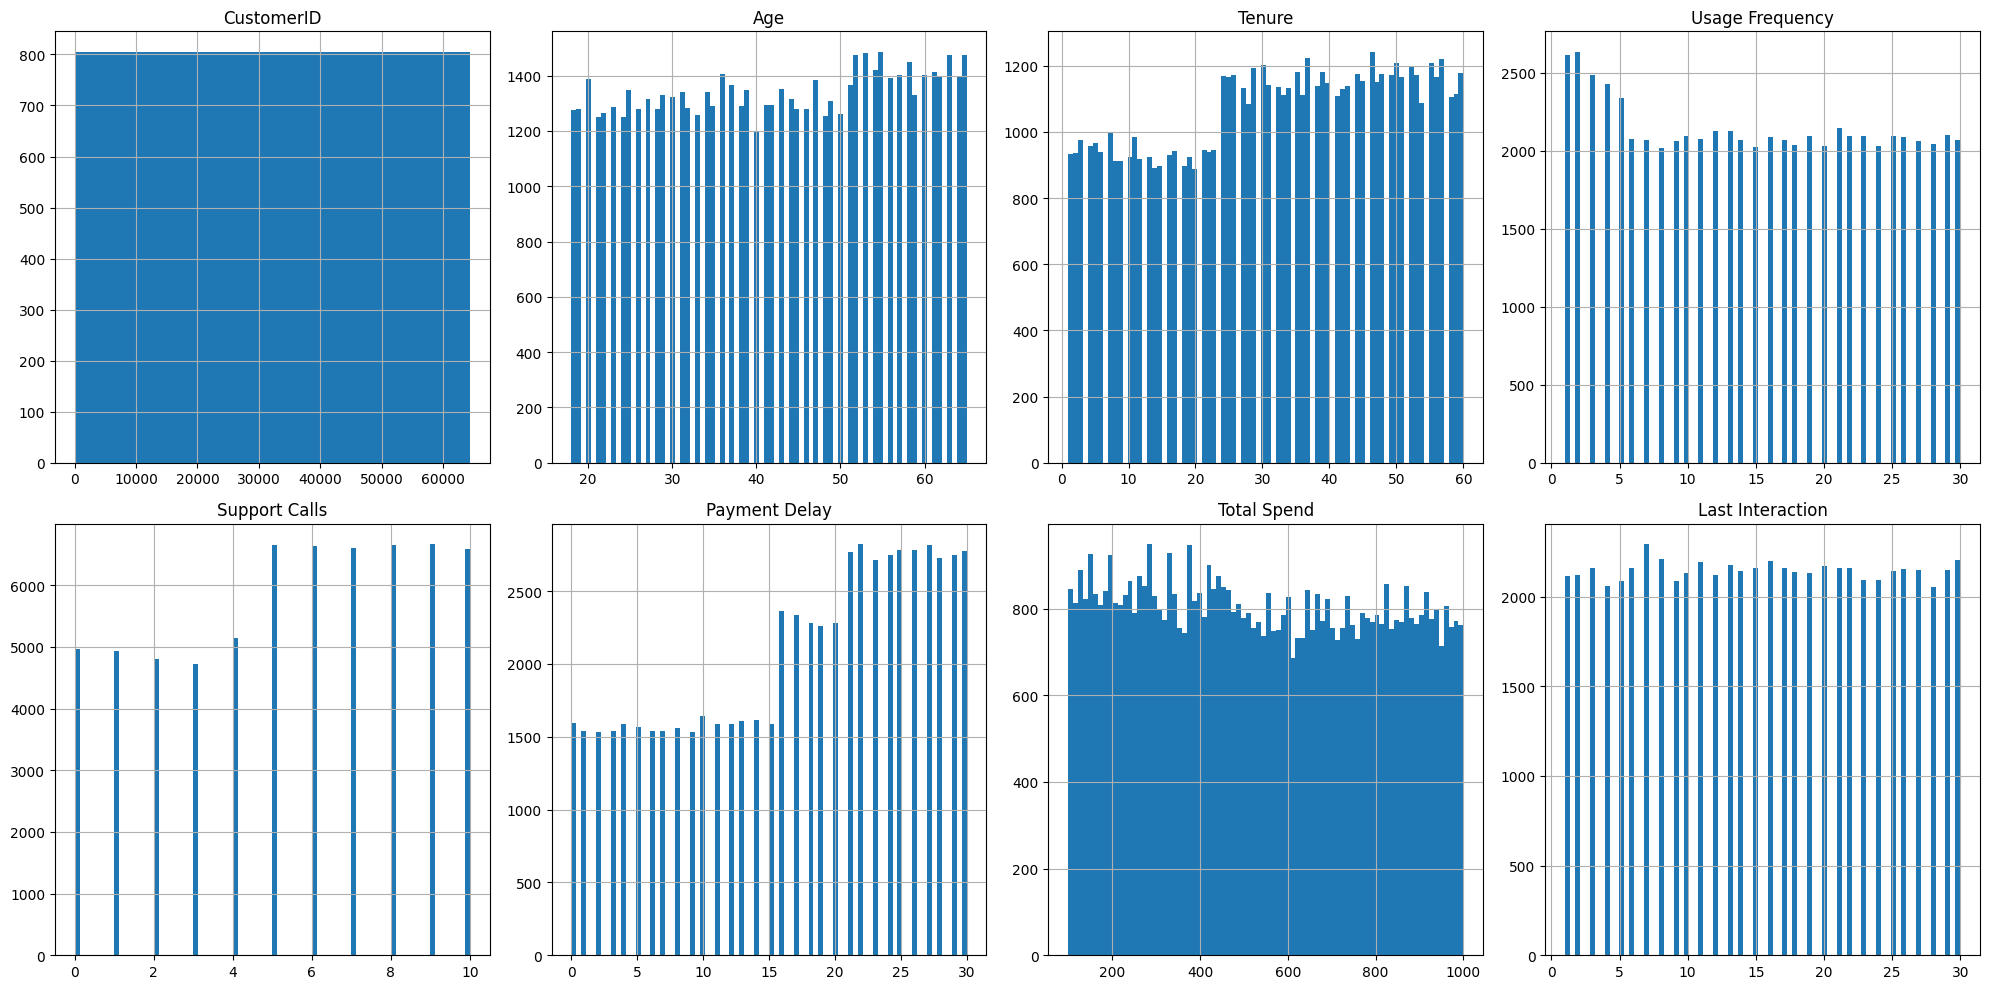

In [138]:
def optimal_bin_count(data):
    n = len(data)
    bin_count = int(2 * np.cbrt(n))
    return bin_count

def plot_numerical_distribution(df, features):
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    ax = ax.flatten()
    
    for i, feature in enumerate(features):
        bin_count = optimal_bin_count(df[feature])
        df[feature].hist(bins=bin_count, ax=ax[i])
        ax[i].set_title(feature)
        
    for j in range(i + 1, len(ax)):
        ax[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
plot_numerical_distribution(train_df, numerical_features_no_churn)

- Boxplot/s to detect outliers.

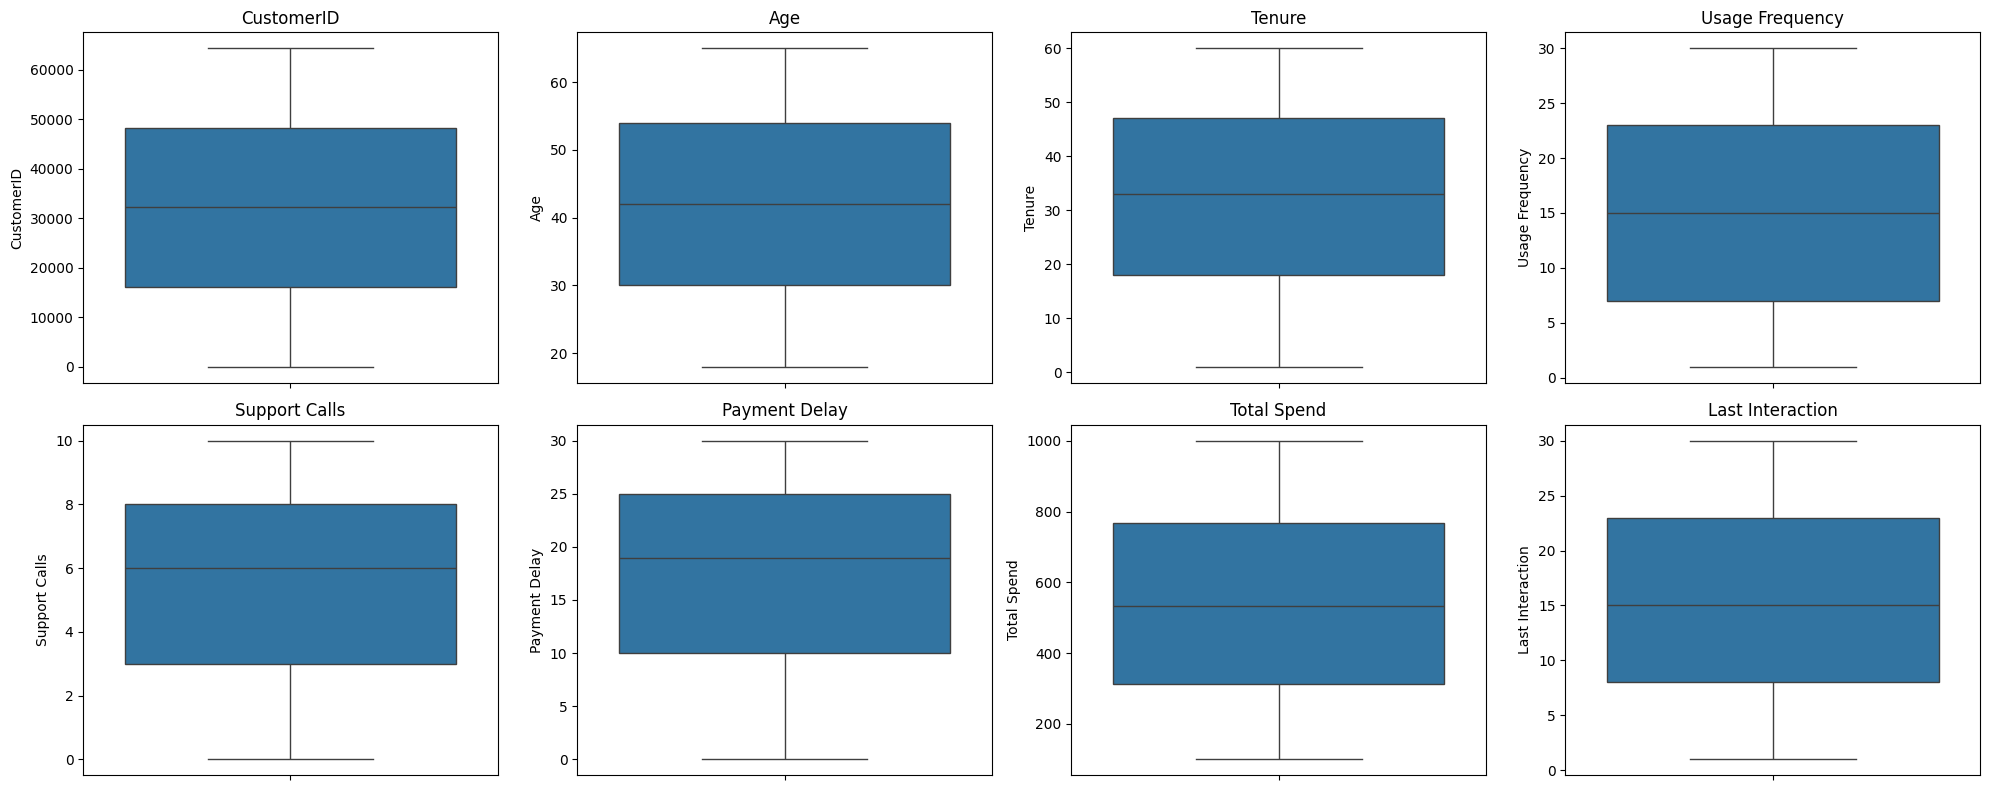

In [139]:
def numerical_boxplot(df, features):    
    fig, ax = plt.subplots(2, 4, figsize=(20, 8))
    ax = ax.flatten()
    
    for i, feature in enumerate(features):
        sns.boxplot(y=feature, data=df, ax=ax[i])
        ax[i].set_title(feature)
    
    for j in range(i + 1, len(ax)):
        ax[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

numerical_boxplot(train_df, numerical_features_no_churn)

- Plot the distribution of categorical features.

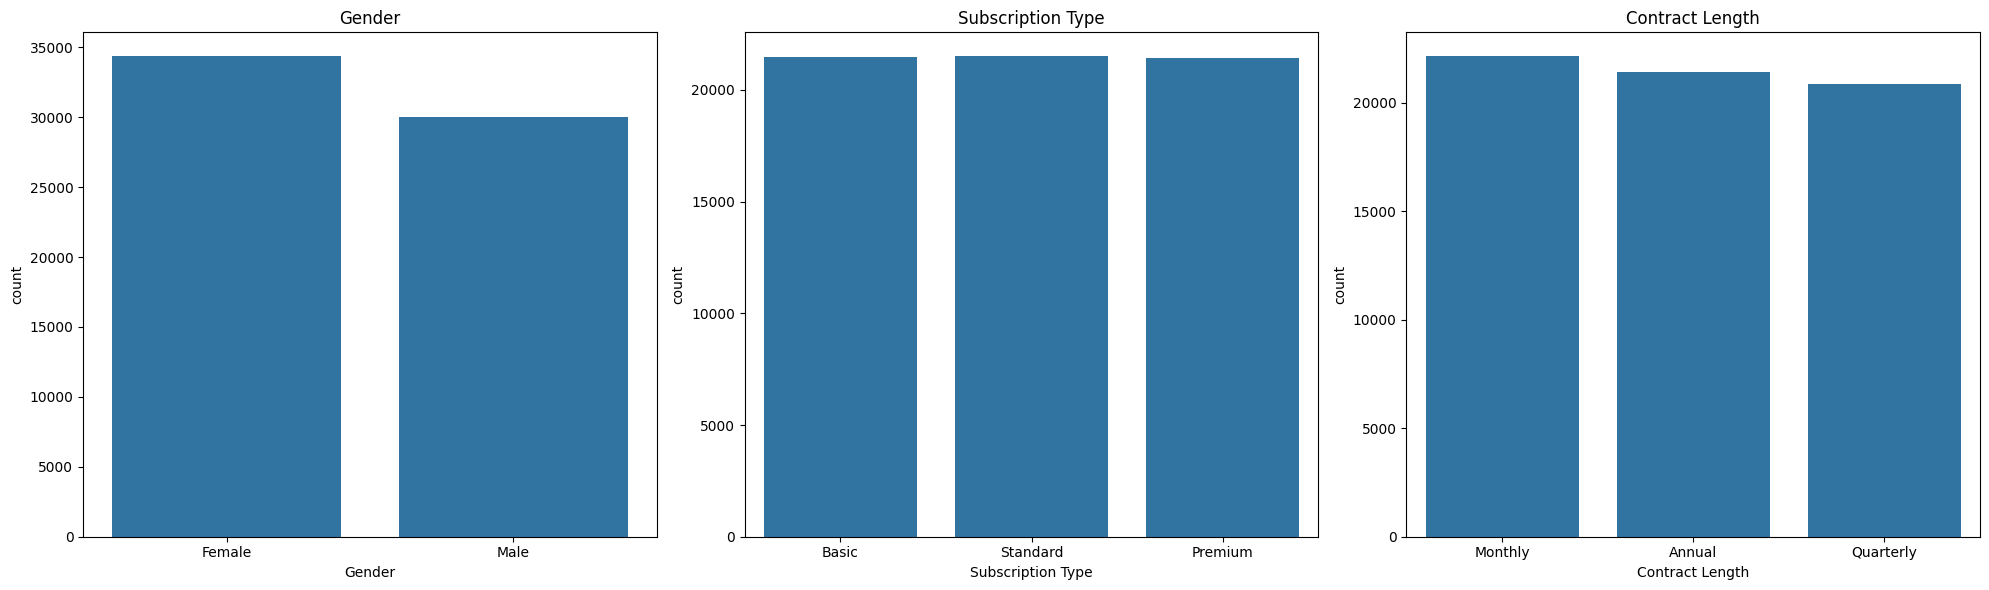

In [140]:
def categorical_distribution_plot(df, features):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, feature in enumerate(features):
        sns.countplot(data=df, x=feature, ax=ax[i])
        ax[i].set_title(feature)
        
    plt.tight_layout()
    plt.show()

categorical_distribution_plot(train_df, categorical_features)

- Check for missing values

In [141]:
missing_values = train_df.isnull().sum()
missing_test = test_df.isnull().sum()

missing_test, missing_values

(CustomerID           1
 Age                  1
 Gender               1
 Tenure               1
 Usage Frequency      1
 Support Calls        1
 Payment Delay        1
 Subscription Type    1
 Contract Length      1
 Total Spend          1
 Last Interaction     1
 Churn                1
 dtype: int64,
 CustomerID           0
 Age                  0
 Gender               0
 Tenure               0
 Usage Frequency      0
 Support Calls        0
 Payment Delay        0
 Subscription Type    0
 Contract Length      0
 Total Spend          0
 Last Interaction     0
 Churn                0
 dtype: int64)

In [142]:
test_df.dropna(inplace=True)
missing_test = test_df.isnull().sum()
missing_test

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

- Check the churn distribution

In [143]:
churn_distribution = train_df['Churn'].value_counts()
churn_distribution

Churn
0    33881
1    30493
Name: count, dtype: int64

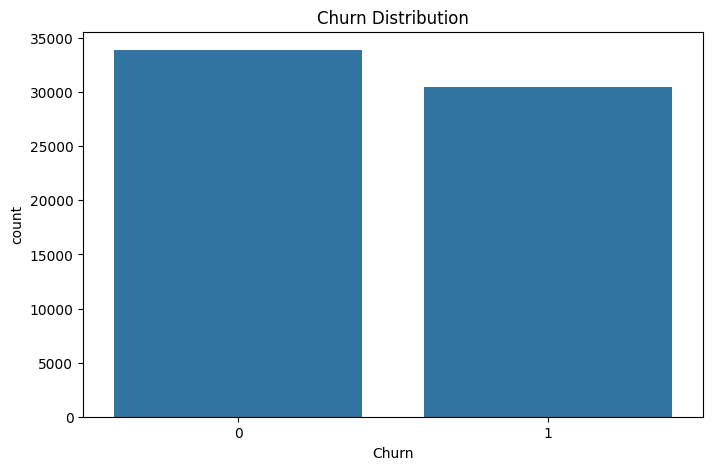

In [144]:
def plot_churn_distribution(data, feature):
    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x=feature)
    plt.title(f'{feature} Distribution')
    plt.show()

plot_churn_distribution(train_df, 'Churn')

- Numerical features vs Churn

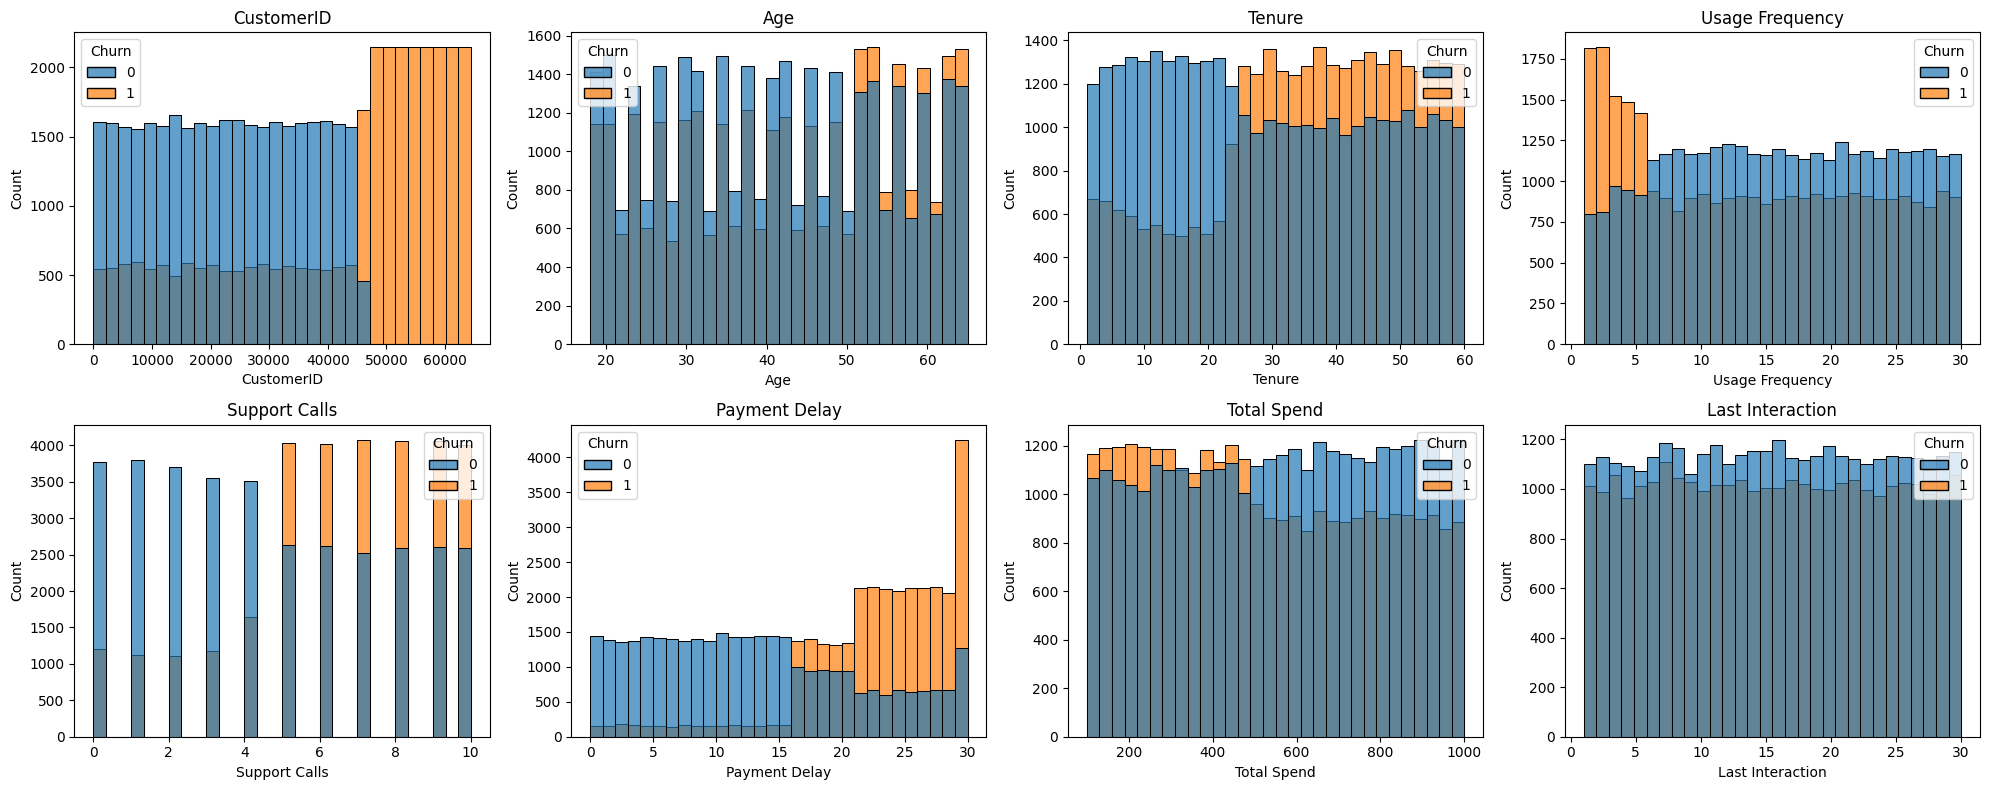

In [145]:
def numerical_churn(df, features):
    fig, ax = plt.subplots(2, 4, figsize=(20, 8))
    ax = ax.flatten()
    
    for i, feature in enumerate(features):
        sns.histplot(data=df, x=feature, hue='Churn', bins=30, ax=ax[i], alpha=0.7)
        ax[i].set_title(feature)
    
    for j in range(i + 1, len(ax)):
        ax[j].set_visible(False)

    
    plt.tight_layout()
    plt.show()
    
numerical_churn(train_df, numerical_features_no_churn)

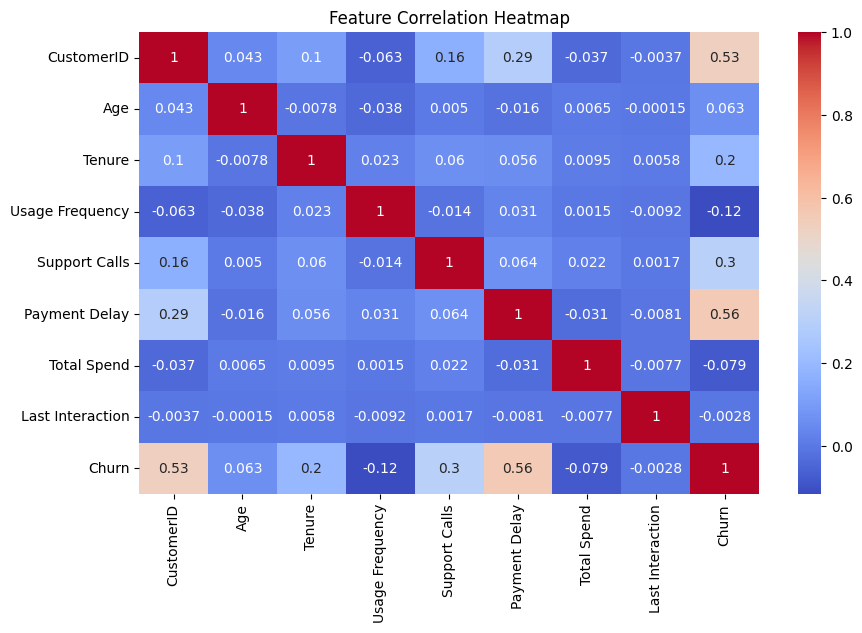

In [146]:
def numerical_heatmap(df, features, row, col):
    plt.figure(figsize=(row, col))
    sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
    plt.title("Feature Correlation Heatmap")
    plt.show()

numerical_heatmap(train_df, numerical_features, 10, 6)

- Categorical features vs Churn

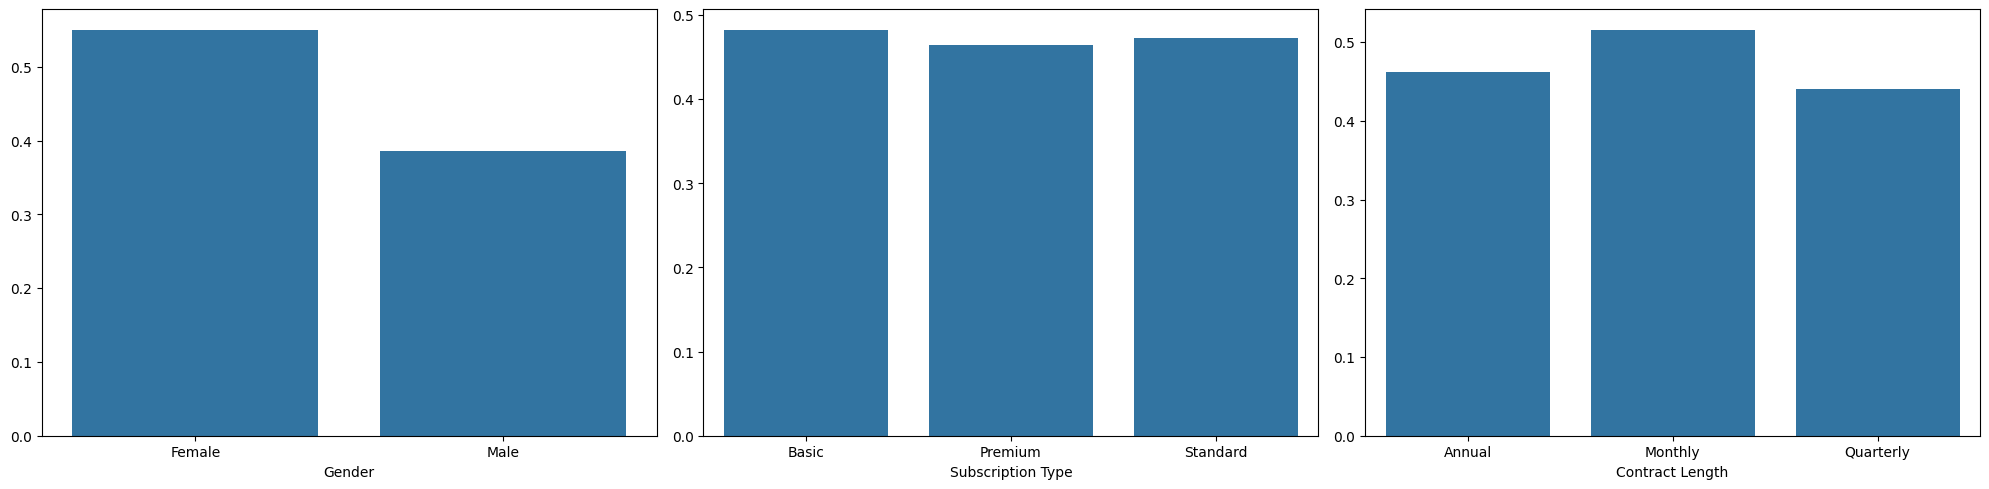

In [147]:
def categorical_churn(df, features):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax = ax.flatten()
    
    for i, feature in enumerate(features):
        churn_rate = df.groupby(feature)['Churn'].mean()
        sns.barplot(x=churn_rate.index, y=churn_rate.values, ax=ax[i])
        
    for j in range(i + 1, len(ax)):
        ax[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

categorical_churn(train_df, categorical_features)        

### **Feature Engineering**

In [148]:
from sklearn.preprocessing import LabelEncoder

- Since there are no missing values, lets go straight into encoding categorical features.

In [149]:
train_df[categorical_features].head()

,Gender,Subscription Type,Contract Length
0,Female,Basic,Monthly
1,Female,Standard,Monthly
2,Male,Premium,Annual
3,Male,Premium,Quarterly
4,Female,Standard,Annual


In [150]:
for i in categorical_features:
    print(train_df[i].unique())

['Female' 'Male']
['Basic' 'Standard' 'Premium']
['Monthly' 'Annual' 'Quarterly']


In [151]:
encoder = LabelEncoder()

train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_features, drop_first=True)

In [152]:
new_categoricals = train_df.select_dtypes(include=['boolean']).columns.tolist()

train_df[new_categoricals].head()

,Gender_Male,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,False,False,False,True,False
1,False,False,True,True,False
2,True,True,False,False,False
3,True,True,False,False,True
4,False,False,True,False,False


In [153]:
train_df[new_categoricals] = train_df[new_categoricals].astype(int)

train_df[new_categoricals].head()

,Gender_Male,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,0,0,0,1,0
1,0,0,1,1,0
2,1,1,0,0,0
3,1,1,0,0,1
4,0,0,1,0,0


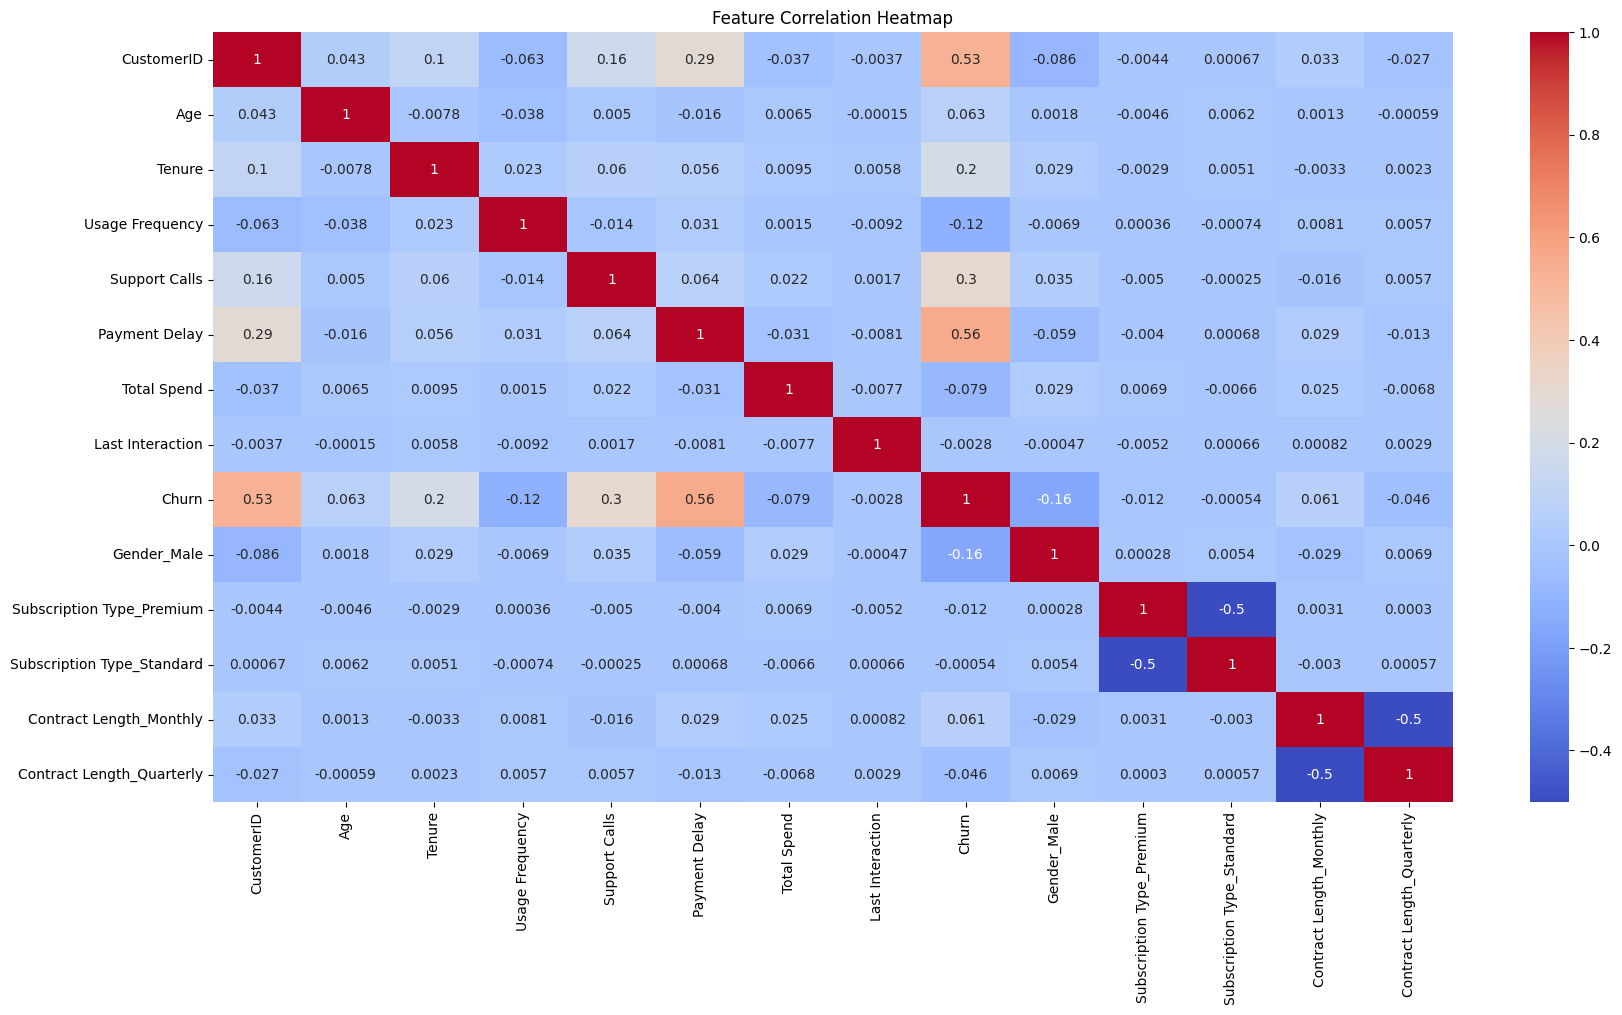

In [154]:
new_numericals = train_df.select_dtypes(include=['float64','int64']).columns.tolist()
numerical_heatmap(train_df, new_numericals, 20, 10)

### **Train the model/s**
- Prepare the dataset

In [155]:
y_train = train_df['Churn']
x_train = train_df.drop(columns=['Churn'])

y_test = test_df['Churn']
x_test = test_df.drop(columns=['Churn'])

#### **XGBoost**

In [156]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import shap

In [157]:
xgb = XGBClassifier(
    n_estimators=300,         
    learning_rate=0.05,       
    max_depth=6,              
    min_child_weight=3,       
    gamma=0.2,                
    subsample=0.8,            
    colsample_bytree=0.8,     
    reg_alpha=0.1,            
    reg_lambda=0.5,           
    scale_pos_weight=2,       
    random_state=42,
    objective="binary:logistic"  
)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [158]:
y_pred = xgb.predict(x_test)

print("XGBoost Classification Report:\n", classification_report(y_test, y_pred))
print("XGBoost AUC-ROC:", roc_auc_score(y_test, y_pred))

XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.74      0.62    190833
         1.0       0.72      0.52      0.60    249999

    accuracy                           0.61    440832
   macro avg       0.63      0.63      0.61    440832
weighted avg       0.64      0.61      0.61    440832

XGBoost AUC-ROC: 0.6291422468672062


In [159]:
# explainer = shap.Explainer(xgb, x_train)
# shap_values = explainer(x_test)

In [160]:
# shap.summary_plot(shap_values, x_test)
# shap.plots.bar(shap_values)
# shap.initjs() 
# # shap.force_plot(explainer.expected_value, shap_values[0], x_test.iloc[0])
# shap.plots.waterfall(shap_values[0])